# Spiked Covariance Model

This notboke

### Demostrate of Edge Statistics of this Model
(It is partially complete and could use a little work )


#### Bulk Edge conventions:  Johnstone(statistics) vs Boucaud(physics)

Depending on your point of view, stats or phys, we can express our uncertainty in $\lambda^{+}$ in terms of $N$ or $M$. 


- Create an ensemble of Gaussian random matrices, each  with a rank 1 perturbation

$$\mathbf{W}^{rand}\;(M\times N)+2\mathbf{\Delta}_{0}\; (rank 1) $$

 and form the Empirical Spectral Density (ESD), $\rho_{emp}(\lambda)$, of the $(M\times M)$ correlation matrix
 
$$\mathbf{X}=\dfrac{1}{N}\mathbf{W}^{T}\mathbf{W}^{T}$$


- Demonstrate the fluctuations in both the MP bulk edge $\lambda^{+}$

- and the (Gaussian) shape of the fluctuations of the spikes $\lambda_{k} > $\lambda^{+}$


#### References

- Spiked Covariance Model of Johnstone

- Applications to Finance, Bouchaud and co-workers

- Sornette's model of Self Organization



In [1]:
import numpy as np
import tensorflow as tf
import pickle, time
from copy import deepcopy
from shutil import copy
from tqdm import tqdm_notebook as tqdm
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import import_ipynb

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
print(sklearn.__version__)

/Users/charlesmartin14/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/charlesmartin14/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


0.19.1


In [2]:
import RMT_Util

importing notebook from RMT_Util.ipynb
3.6.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version 1.14.2
scipy version 1.0.1
tensforflow version 1.5.0-dev20171116
keras version 2.1.5
sklearn version 0.19.1
powerlaw version 1.4.3


Using TensorFlow backend.


### Create Random Matrix  

$$N\times M=1000\times 500$$

$$\mu=0,\; \sigma=\dfrac{1}{\sqrt{N}}$$

#### will add rank 1 perturbation

using Python API

https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html


% spikes outside bulk 0.00
% sigma 0.9953


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


0.9953047167192505

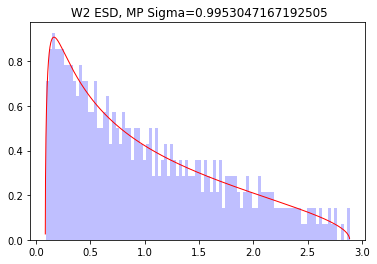

In [3]:
W = np.random.normal(0.0, 1.0/np.sqrt(1000), (1000,500))
Q = np.max(W.shape)/np.min(W.shape)
evals, _ = RMT_Util.eigenspectrum(W)
RMT_Util.plot_ESD_and_fit(eigenvalues=evals, Q=Q)

### Add a random Rank 1 perturbation

#### check that we see a spike

$$\mathbf{W}=\mathbf{W}^{rand}+2\mathbf{\Delta}$$

$\mathbf{\Delta}$ is a 1-D random vector , same mean and variance as $\mathbf{W}^{rand}$


% spikes outside bulk 0.00
% sigma 1.1695


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


1.1694848374954956

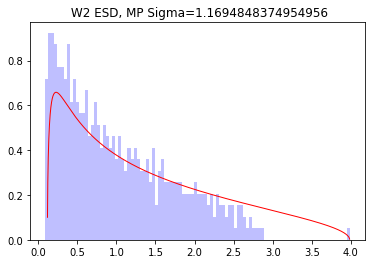

In [4]:
R = np.random.normal(0.0, 1.0/np.sqrt(1000), (1000,500))
D = np.zeros_like(R)
D[0]= np.random.normal(0.0, 1.0/np.sqrt(1000), (500))
W = R+2.0*D
evals, _ = RMT_Util.eigenspectrum(W)
RMT_Util.plot_ESD_and_fit(eigenvalues=evals, Q=Q)

### Generate ensemble (500) of Matrices w/(the same, simple) Rank 1 perturbation

$$\mathbf{W}=\mathbf{W}^{rand}+2\Delta_{0}$$

where

$$\Delta_{0}=S_{min}=Q^{-1/4}$$

is the minimum value needed to generate a spike


### Mean and Variance for Spiked Covariance

#### Johnstone Conventions

http://www.maths.usyd.edu.au/u/austms2013/talks/aust13Johnstone.pdf

In [5]:
def mp_var_scale(Q):
    g = 1.0/Q #gamma
    numer = np.cbrt(np.cbrt(g))
    denom = np.cbrt(1.0+np.sqrt(g))**4
    return numer/denom

In [6]:
def rho(Q,S):
    """MP mean value of max eigenvalue"""
    g = 1.0/Q
    h = S*S
    return (1.0+h)*(1.0+(g/h))

In [7]:
def tau_squared(Q,S):
    """MP variance of max eigenvalue - rho (mean)"""
    h = S*S
    h1 = (1.0+h)
    h2 = h*h
    g = 1.0/Q
    return 2.0*h1*h1*(1.0-(g/(h2)))

#### check that these methods match the Bouchaud equations

ONly checked mean value so far...still do not understand variance scaling

In [9]:
#rho(Q,S), RMT_Util.spike_lmax(S,Q)

#### Compute adjusted errors 

$$adjusted\;errors\;=\;\dfrac{\lambda_{max}-\rho(Q,S)}{\tau(Q,S)}$$

#### Check finite size scaling 

$$adjusted\;errors\times N^{1/2}\rightarrow N(0,1)$$

Where we have

$$\gamma=\dfrac{1}{Q}$$

and 

$$h=S=2\times S_{min}$$

In [10]:
S_min = RMT_Util.spike_min(Q)
evals = []
max_evals = []
max_errs = []
adjusted_errs = []


N, M = 1000, 500
for ne in tqdm(range(1,1000)):
    R = np.random.normal(0.0, 1.0/np.sqrt(N), (N,M))
    D = np.zeros_like(R)

    D[0,0]= 1.2*S_min
    
    W = R+D
    Q = np.max(W.shape)/np.min(W.shape)
    evals, _ = RMT_Util.eigenspectrum(W)
    
    #RMT_Util.plot_ESD_and_fit(eigenvalues=evals, Q=Q, sigma=1.0, alpha=0.25)
    #sigma = RMT_Util.plot_ESD_and_fit(eigenvalues=evals, Q=Q, alpha=0.25, verbose=False)

    S = np.max(np.abs(D))
    emax = np.max(evals)
    max_evals.append(emax)
    max_errs.append(emax-RMT_Util.spike_lmax(S,Q))
    adj_err= (emax-RMT_Util.spike_lmax(S,Q))/np.sqrt(tau_squared(Q,S))
    adjusted_errs.append(adj_err)
    
plt.show()


Text(0.5,1,'distrbution of adjusted errors in predicting spike at $2\\Delta=2Q^{-1/4}$  for $Q=2\\;\\;N,M=1000,500$')

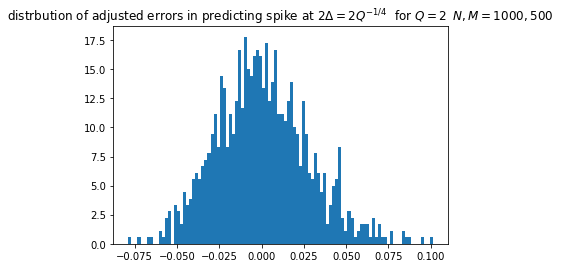

In [11]:
plt.hist(adjusted_errs,bins=100, density=True);
plt.title(r"distrbution of adjusted errors in predicting spike at $2\Delta=2Q^{-1/4}$  for $Q=2\;\;N,M=1000,500$")

#### Check that finite size scaling is $N^{1/2}$ and NOT $M^{1/2}$

In [12]:
np.std(adjusted_errs), np.sqrt(1/M),np.std(adjusted_errs)* np.sqrt(M)

(0.027236485069126987, 0.044721359549995794, 0.60902632082726)

In [13]:
np.std(adjusted_errs), np.sqrt(1/N), np.std(adjusted_errs)* np.sqrt(N)

(0.027236485069126987, 0.03162277660168379, 0.8612932827560988)

### Bouchaud Scaling - at the EDGE he has $M^{-2/3}$ 

### BUT for the spikes it is $T^{-1/2}$

see:  https://arxiv.org/pdf/0910.1205.pdf

equations (66) for MP,  and (72) for spikes, with the text just below

